## Importación de Librerías ##

In [95]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon
from sklearn.cluster import KMeans
from gap_statistic import OptimalK
import plotly.graph_objs as go
from mpl_toolkits.basemap import Basemap
from sklearn.preprocessing import StandardScaler

# Lectura de los datos y solución de valores nulos #

In [76]:
df = pd.read_csv('files/weatherAUS.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,0.0
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,0.0
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,0.0
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,1.0
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145407,2017-06-20,Uluru,3.5,21.8,0.0,NaN,NaN,E,31.0,ESE,...,27.0,1024.7,1021.2,NaN,NaN,9.4,20.9,No,No,0.0
145408,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No,0.0
145409,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No,0.0
145410,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No,0.0


In [77]:
vacios_original=df.isna().sum()
vacios_original

Date                    0
Location                0
MinTemp              1484
MaxTemp              1253
Rainfall             3260
Evaporation         62754
Sunshine            69796
WindGustDir         10316
WindGustSpeed       10253
WindDir9am          10562
WindDir3pm           4226
WindSpeed9am         1767
WindSpeed3pm         3061
Humidity9am          2653
Humidity3pm          4505
Pressure9am         15061
Pressure3pm         15024
Cloud9am            55870
Cloud3pm            59336
Temp9am              1766
Temp3pm              3607
RainToday            3260
RainTomorrow         3259
RainfallTomorrow     3259
dtype: int64

## Clustering ##

Para solventar el problema de los datos vacíos decimos agrupar las ciudades en distintos clusters y completar aquellos datos vacíos con datos del mismo cluster para la misma fecha.

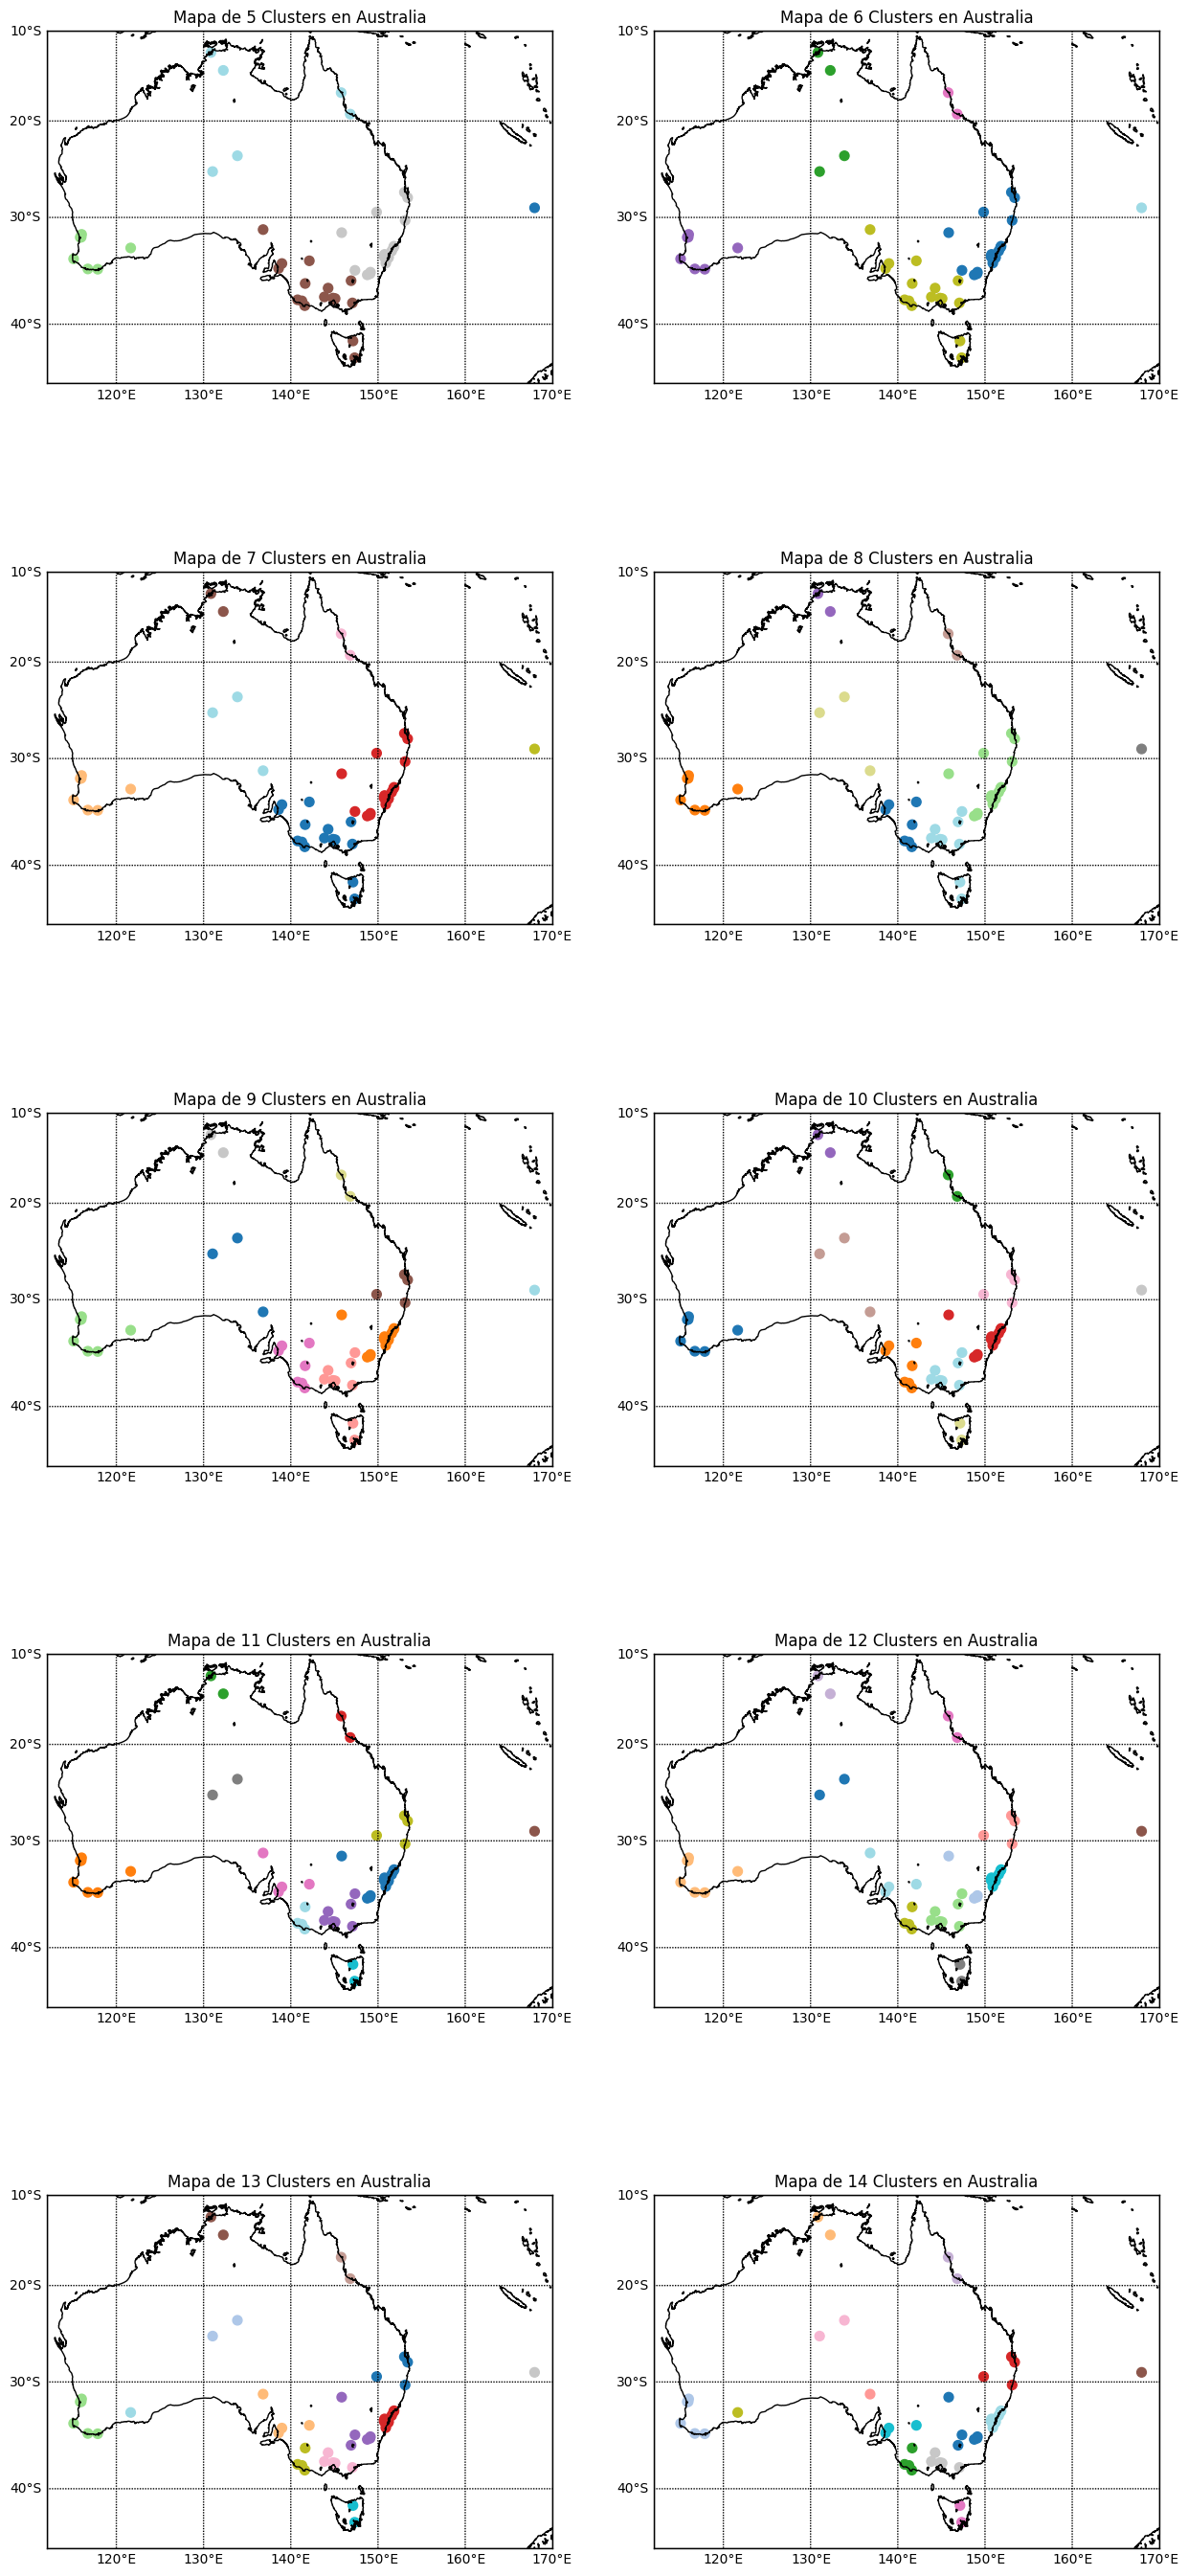

In [78]:
cities=df['Location'].unique().copy()
cities_coord = {'Adelaide': (-34.9285, 138.6007),
                'Albany': (-35.0031, 117.8657),
                'Albury': (-36.0737, 146.9135),
                'AliceSprings': (-23.6980, 133.8807),
                'BadgerysCreek': (-33.8813, 150.7400),
                'Ballarat': (-37.5622, 143.8503),
                'Bendigo': (-36.7570, 144.2794),
                'Brisbane': (-27.4698, 153.0251),
                'Cairns': (-16.9186, 145.7781),
                'Canberra': (-35.2809, 149.1300),
                'Cobar': (-31.4983, 145.8344),
                'CoffsHarbour': (-30.2963, 153.1131),
                'Dartmoor': (-37.9223, 141.2760),
                'Darwin': (-12.4634, 130.8456),
                'GoldCoast': (-28.0167, 153.4000),
                'Hobart': (-42.8821, 147.3272),
                'Katherine': (-14.4644, 132.2630),
                'Launceston': (-41.4545, 147.1317),
                'Melbourne': (-37.8136, 144.9631),
                'MelbourneAirport': (-37.6690, 144.8410),
                'Mildura': (-34.2083, 142.1270),
                'Moree': (-29.4638, 149.8413),
                'MountGambier': (-37.8241, 140.7798),
                'MountGinini': (-35.5294, 148.7720),
                'Newcastle': (-32.9283, 151.7817),
                'Nhil': (-36.3328, 141.6503),
                'NorahHead': (-33.2833, 151.5667),
                'NorfolkIsland': (-29.0408, 167.9547),
                'Nuriootpa': (-34.4667, 138.9833),
                'PearceRAAF': (-31.6675, 116.0158),
                'Penrith': (-33.7581, 150.6950),
                'Perth': (-31.9522, 115.8589),
                'PerthAirport': (-31.9405, 115.9660),
                'Portland': (-38.3511, 141.6056),
                'Richmond': (-33.6000, 150.7500),
                'Sale': (-38.1063, 147.0674),
                'SalmonGums': (-32.9819, 121.6431),
                'Sydney': (-33.8688, 151.2093),
                'SydneyAirport': (-33.9461, 151.1772),
                'Townsville': (-19.2583, 146.8169),
                'Tuggeranong': (-35.4244, 149.0887),
                'Uluru': (-25.3444, 131.0369),
                'WaggaWagga': (-35.1082, 147.3598),
                'Walpole': (-34.9772, 116.7317),
                'Watsonia': (-37.7114, 145.0831),
                'Williamtown': (-32.8150, 151.8428),
                'Witchcliffe': (-34.0264, 115.1000),
                'Wollongong': (-34.4241, 150.8931),
                'Woomera': (-31.1997, 136.8256)}

cities_coord = pd.DataFrame.from_dict(cities_coord, orient='index', columns=['lat', 'lon'])
cities_coord['mean_rain'] = df.groupby('Location')['Rainfall'].mean()
xPos=cities_coord[['lat','lon','mean_rain']].copy()
Nc= range(1, 20)
kmeans= [KMeans(n_clusters=i, n_init=10) for i in Nc]
score = [kmeans[i].fit(xPos).score(xPos) for i in range(len(kmeans))]
# plt.plot(Nc,score)
# plt.xlabel('NumberofClusters')
# plt.ylabel('Score')
# plt.title('ElbowCurve')
# plt.show()

num_clusters = range(5, 15)
num_rows = len(num_clusters) // 2 + len(num_clusters) % 2

fig, axes = plt.subplots(num_rows, 2, figsize=(15, num_rows * 7))
fig.subplots_adjust(hspace=0.3)

for i, num_cluster in enumerate(num_clusters):
    # Elegir el número óptimo de clusters
    kmeans = KMeans(n_clusters=num_cluster, n_init=10).fit(xPos)
    centroids = kmeans.cluster_centers_

    # Asignar cada punto a su respectivo cluster
    xPos['cluster'] = kmeans.predict(xPos)
    labels = np.unique(xPos['cluster'])
    palette = sns.color_palette("hot", len(labels))
    xPos['cluster'] = xPos['cluster'].astype('category')

    # Calcular la fila y la columna actual
    row = i // 2
    col = i % 2

    # Crear un mapa de Australia para el subplot actual
    ax = axes[row, col]
    m = Basemap(
        projection='merc',
        llcrnrlat=-45, urcrnrlat=-10,
        llcrnrlon=112, urcrnrlon=170,
        resolution='i',
        ax=ax
    )
    m.drawmapboundary()
    m.drawcoastlines()
    m.drawcountries()
    m.drawparallels(np.arange(-90., 91., 10.), labels=[1, 0, 0, 0])
    m.drawmeridians(np.arange(-180., 181., 10.), labels=[0, 0, 0, 1])

    # Crear un gráfico de dispersión centrado en Australia
    scatter = m.scatter(
        xPos['lon'], xPos['lat'],
        c=xPos['cluster'], cmap='tab20', s=50,
        latlon=True
    )

    # Configurar título y leyenda para el subplot
    ax.set_title(f'Mapa de {num_cluster} Clusters en Australia')
    #plt.colorbar(scatter, ax=ax, label='Cluster')

# Eliminar subplots vacíos si es necesario
if len(num_clusters) % 2 != 0:
    fig.delaxes(axes[num_rows - 1, 1])

plt.show()

Decidimos utilizar 11 clusters debido a que consideramos es la cantidad que mejor se ajusta a los datos sin hacer overfitting.

In [79]:
# Elegir el número óptimo de clusters
kmeans = KMeans(n_clusters=11, n_init=10).fit(xPos)
centroids = kmeans.cluster_centers_

# Asignar cada punto a su respectivo cluster
xPos['cluster'] = kmeans.predict(xPos)
labels = np.unique(xPos['cluster'])
palette = sns.color_palette("hot", len(labels))
xPos['cluster'] = xPos['cluster'].astype('category')

df['Cluster']=df['Location'].map(xPos['cluster'])
df.to_csv('files/weatherAUS_cluster.csv', index=False)

## Corrigiendo datos vacíos ##

Dado que estamos hablando de variables climáticas y se puede considerar que estan no presentan grandes variaciones para regiones cercanas, al clusterizar las ciudades podemos estimar aquellos datos vacíos como la media de los datos de las ciudades del mismo cluster para la misma fecha.

In [80]:
numeric_columns = df.select_dtypes(include=[float, int]).columns
non_numeric_columns = df.select_dtypes(include=[object]).columns

In [81]:
# Agrupar por 'Cluster' y 'Date' y llenar los valores nulos con la media del grupo
df_numeric = df.groupby(['Cluster', 'Date'])[numeric_columns].transform(lambda x: x.fillna(x.mean()))

# Asignar los valores llenos al DataFrame original
df[numeric_columns] = df_numeric

# Función para llenar los valores nulos con la moda
def fill_with_mode(x):
    mode_value = x.mode()
    if len(mode_value) > 0:
        return x.fillna(mode_value.iloc[0])
    else:
        return x

# Agrupar por 'Cluster' y 'Date' y llenar los valores nulos con la moda del grupo
df_non_numeric = df.groupby(['Cluster', 'Date'])[non_numeric_columns].transform(fill_with_mode)

# Asignar los valores llenos al DataFrame original
df[non_numeric_columns] = df_non_numeric

In [82]:
vacios_transformado=df.isna().sum()
comparison_df = pd.DataFrame({'vacios_antes': vacios_original, 'vacios_despues': vacios_transformado})
total_datos = len(df)
comparison_df['porcentaje recuperado'] = 100 * (1 - comparison_df['vacios_despues'] / comparison_df['vacios_antes'])
comparison_df['porcentaje recuperado'] = comparison_df['porcentaje recuperado'].apply(lambda x: f'{x:.2f}%')
comparison_df['porcentaje_completo'] = 100 * (1 - comparison_df['vacios_despues'] / total_datos)
comparison_df['porcentaje_completo'] = comparison_df['porcentaje_completo'].apply(lambda x: f'{x:.2f}%')


# Mostrar el DataFrame con la comparación
comparison_df

,vacios_antes,vacios_despues,porcentaje recuperado,porcentaje_completo
Cloud3pm,59336.0,2027,96.58%,98.61%
Cloud9am,55870.0,1750,96.87%,98.80%
Cluster,NaN,0,nan%,100.00%
Date,0.0,0,nan%,100.00%
Evaporation,62754.0,3176,94.94%,97.82%
Humidity3pm,4505.0,9,99.80%,99.99%
Humidity9am,2653.0,9,99.66%,99.99%
Location,0.0,0,nan%,100.00%
MaxTemp,1253.0,4,99.68%,100.00%
MinTemp,1484.0,3,99.80%,100.00%


Podemos notar que el método fue efectivo, habiendo recuperado grandes cantidades de datos y con registros totales completos que se acercan al 100%. Ahora podríamos considerar eliminar los registros que presenten valores nulos y no deberíamos perder grandes vólumenes de información.

In [83]:
df_sin_nan = df.dropna()
df_sin_nan.to_csv('files/weatherAUS_sin_nan.csv', index=False)
df=df_sin_nan.copy()
df['Date'] = pd.to_datetime(df['Date'])
df.info()

## Eliminación de Outliers ##
Diseñamos una función que recibe el dataframe y nos elimina del mismo aquellos registros que presentan outliers en alguna de las variables númericas teniendo en cuenta un threshold que puede ser modificado para hacerlo mas o menos restrictivo.

In [131]:
def remove_outliers(df, threshold=1.5):
    cleaned_df = df.copy()
    columns = df.drop(['Rainfall','RainToday','RainTomorrow','RainfallTomorrow'],axis=1).select_dtypes(include=[float, int])
    for column in columns:
        if column in df.columns:
            # Calcular el rango intercuartílico (IQR)
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1

            # Definir los límites para identificar valores atípicos
            lower_limit = Q1 - threshold * IQR
            upper_limit = Q3 + threshold * IQR

            # Eliminar valores atípicos
            cleaned_df = cleaned_df[(cleaned_df[column] >= lower_limit) & (cleaned_df[column] <= upper_limit)]

    return cleaned_df

df = remove_outliers(df)

# Visualización y análisis de datos #

In [112]:
def city_dataframe(city):
    df_city = df[df['Location'] == city]
    return df_city

def cluster_dataframe(cluster):
    df_cluster = df[df['Cluster'] == cluster]
    return df_cluster

def plot_temperature(df):
    sns.set(style="whitegrid")
    plt.figure(figsize=(15, 5))
    sns.lineplot(x="Date", y="MaxTemp", data=df, color='red')
    sns.lineplot(x="Date", y="MinTemp", data=df, color='blue')
    plt.xticks(rotation=90)
    plt.xticks(np.arange(0, len(df), 50))
    plt.show()

def plot_variables(df):
    sns.set(style="darkgrid")

    # Obtiene una lista de todas las columnas numéricas del DataFrame
    numeric_columns = df.drop(['Rainfall','RainfallTomorrow'],axis=1).select_dtypes(include=[float, int]).columns

    # Calcula el número de filas y columnas necesarias para el ploteo
    num_rows = (len(numeric_columns) + 1) // 2
    num_cols = 2

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(3 * num_rows, 20 * num_cols))

    # Espacio entre los subplots
    plt.subplots_adjust(wspace=1, hspace=1)

    # Colores distintos para los histogramas
    colors = sns.color_palette("Set2", n_colors=len(numeric_columns))

    # Itera a través de las columnas numéricas y crea un histograma para cada una
    for i, col in enumerate(numeric_columns):
        row = i // num_cols
        col_idx = i % num_cols

        # Selecciona un color diferente para cada histograma
        color = colors[i]

        sns.histplot(data=df, x=col, kde=True, color=color, ax=axs[row, col_idx])

        axs[row, col_idx].set_xlabel(col, fontsize=30)
        axs[row, col_idx].set_ylabel("Count",fontsize=20)

        # Cambia el tamaño de letra de los ejes X y Y
        axs[row, col_idx].tick_params(axis='x', labelsize=20)
        axs[row, col_idx].tick_params(axis='y', labelsize=20)

    # Elimina cualquier subplot no utilizado
    for i in range(len(numeric_columns), num_rows * num_cols):
        row = i // num_cols
        col_idx = i % num_cols
        fig.delaxes(axs[row, col_idx])

    # Añade un título general a la figura
    if len(df['Cluster'].unique()) == 1:
        fig.suptitle(f"Histogramas de variales numéricas para el Cluster: {df['Cluster'].iloc[0]}", fontsize=30)
    elif len(df['Location'].unique()) == 1:
        fig.suptitle(f"Histogramas de variales numéricas: {df['Location'].iloc[0]}", fontsize=30)
    else:
        fig.suptitle(f"Histogramas de variales numéricas", fontsize=30)

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajusta el espacio para el título general
    plt.show()

def matriz_correlacion(df):
    corr = df.drop(['Rainfall','RainfallTomorrow'],axis=1).select_dtypes(include=[float, int]).corr()

    #mask = np.triu(np.ones_like(corr, dtype=bool))
    plt.figure(figsize=(20, 15))

    ax = sns.heatmap(
        corr,
        #mask = mask,
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True,
        annot = True,
        annot_kws = {'size': 15},
        
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    )

        # Añade un título general a la figura
    if len(df['Cluster'].unique()) == 1:
        fig.suptitle(f"Matriz de Correlación para el Cluster: {df['Cluster'].iloc[0]}", fontsize=30)
    elif len(df['Location'].unique()) == 1:
        fig.suptitle(f"Matriz de Correlación: {df['Location'].iloc[0]}", fontsize=30)
    else:
        fig.suptitle(f"Matriz de Correlación", fontsize=30)

    plt.show()

def global_boxplots(df):
    # Asegúrate de que todas las columnas sean numéricas
    columnas_numericas = df.drop(['Rainfall','RainfallTomorrow'],axis=1).select_dtypes(include=['number'])
    
    if columnas_numericas.empty:
        print("No hay columnas numéricas en el DataFrame.")
        return
    
    # Normalizar las columnas numéricas
    scaler = StandardScaler()
    columnas_numericas_normalized = pd.DataFrame(scaler.fit_transform(columnas_numericas), columns=columnas_numericas.columns)
    
    # Obtener la cantidad de datos disponibles
    cantidad_datos = len(df)
    
    # Crear una lista de títulos de columnas rotados
    column_titles = [col for col in columnas_numericas_normalized.columns]
    
    # Graficar los boxplots de las columnas numéricas normalizadas con rango en el eje Y de -4 a 4
    plt.figure(figsize=(20, 10))
    plt.title("Boxplots para todas las variables")
    boxplot = plt.boxplot(columnas_numericas_normalized.values, vert=True)
    
    # Rotar los títulos de las columnas
    plt.xticks(range(1, len(columnas_numericas_normalized.columns) + 1), column_titles, rotation=90)
    
    plt.xlabel("Variables")
    plt.ylabel("Valores Normalizados")
    plt.ylim(-4, 4)  # Establecer el rango en el eje Y
    plt.show()
    
    # Imprimir la cantidad de datos disponibles
    print(f"Cantidad de datos disponibles en el DataFrame: {cantidad_datos}")

def date_boxplots(df, year, month):
    # Asegúrate de que la columna 'Date' sea de tipo datetime
    df1 = df.drop(['Rainfall','RainfallTomorrow'],axis=1).copy()  # Realizar una copia del DataFrame para evitar el SettingWithCopyWarning

    # Filtrar el DataFrame por el año y el mes específicos
    filtered_df1 = df1[(df1['Date'].dt.year == year) & (df1['Date'].dt.month == month)]
    
    if filtered_df1.empty:
        print("No hay datos para el año y mes especificados.")
        return
    
    # Seleccionar solo las columnas numéricas
    columnas_numericas = filtered_df1.select_dtypes(include=['number'])
    
    # Normalizar las columnas numéricas
    scaler = StandardScaler()
    columnas_numericas_normalized = pd.DataFrame(scaler.fit_transform(columnas_numericas), columns=columnas_numericas.columns)
    
    # Obtener la cantidad de datos disponibles
    cantidad_datos = len(filtered_df1)
    
    # Crear una lista de títulos de columnas rotados
    column_titles = [col for col in columnas_numericas_normalized.columns]
    
    # Graficar los boxplots de las columnas numéricas normalizadas con rango en el eje Y de -4 a 4
    plt.figure(figsize=(20, 10))
    plt.title(f"Boxplots para {year}/{month}")
    boxplot = plt.boxplot(columnas_numericas_normalized.values, vert=True)
    
    # Rotar los títulos de las columnas
    plt.xticks(range(1, len(columnas_numericas_normalized.columns) + 1), column_titles, rotation=90)
    
    plt.xlabel("Variables")
    plt.ylabel("Valores Normalizados")
    plt.ylim(-4, 4)  # Establecer el rango en el eje Y
    plt.show()
    
    # Imprimir la cantidad de datos disponibles
    print(f"Cantidad de datos disponibles para {year}/{month}: {cantidad_datos}")

def graficos(df):
    #pd.plotting.scatter_matrix(df, figsize=(20, 10))
    plot_variables(df)
    matriz_correlacion(df)
    global_boxplots(df)

Usamos la función gráfico para plotear distintos gráficos para el dataframe.

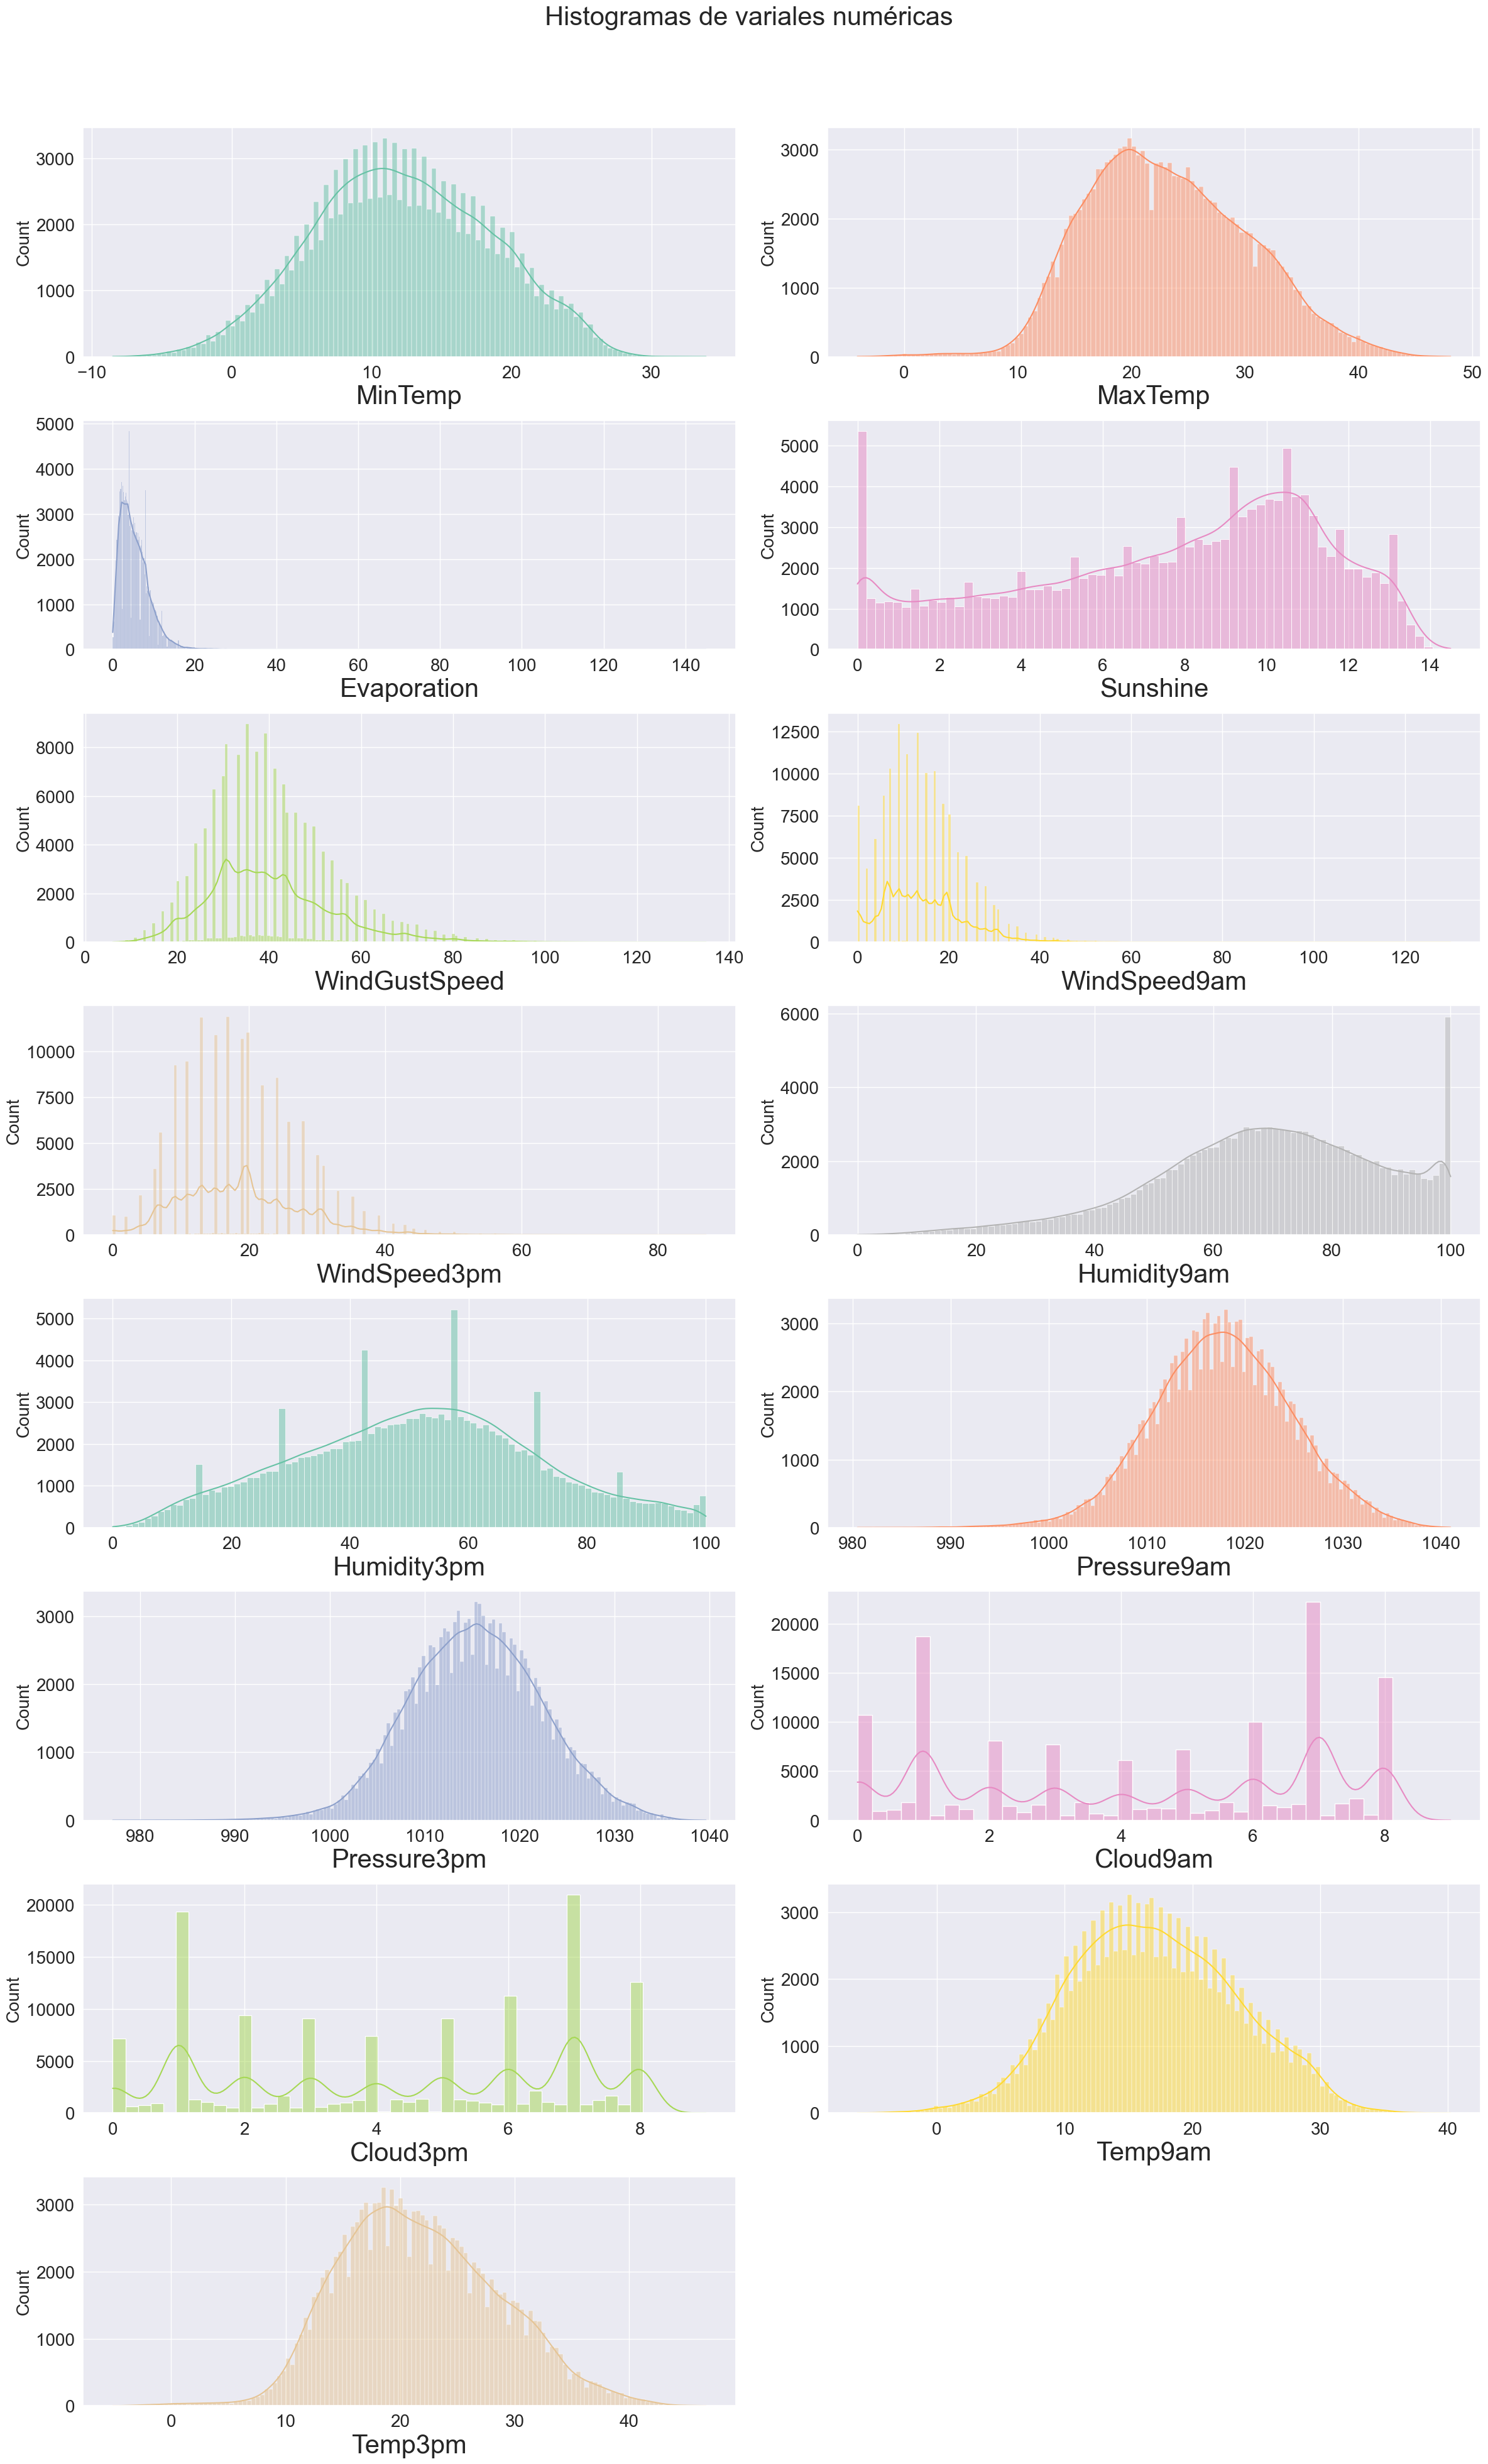

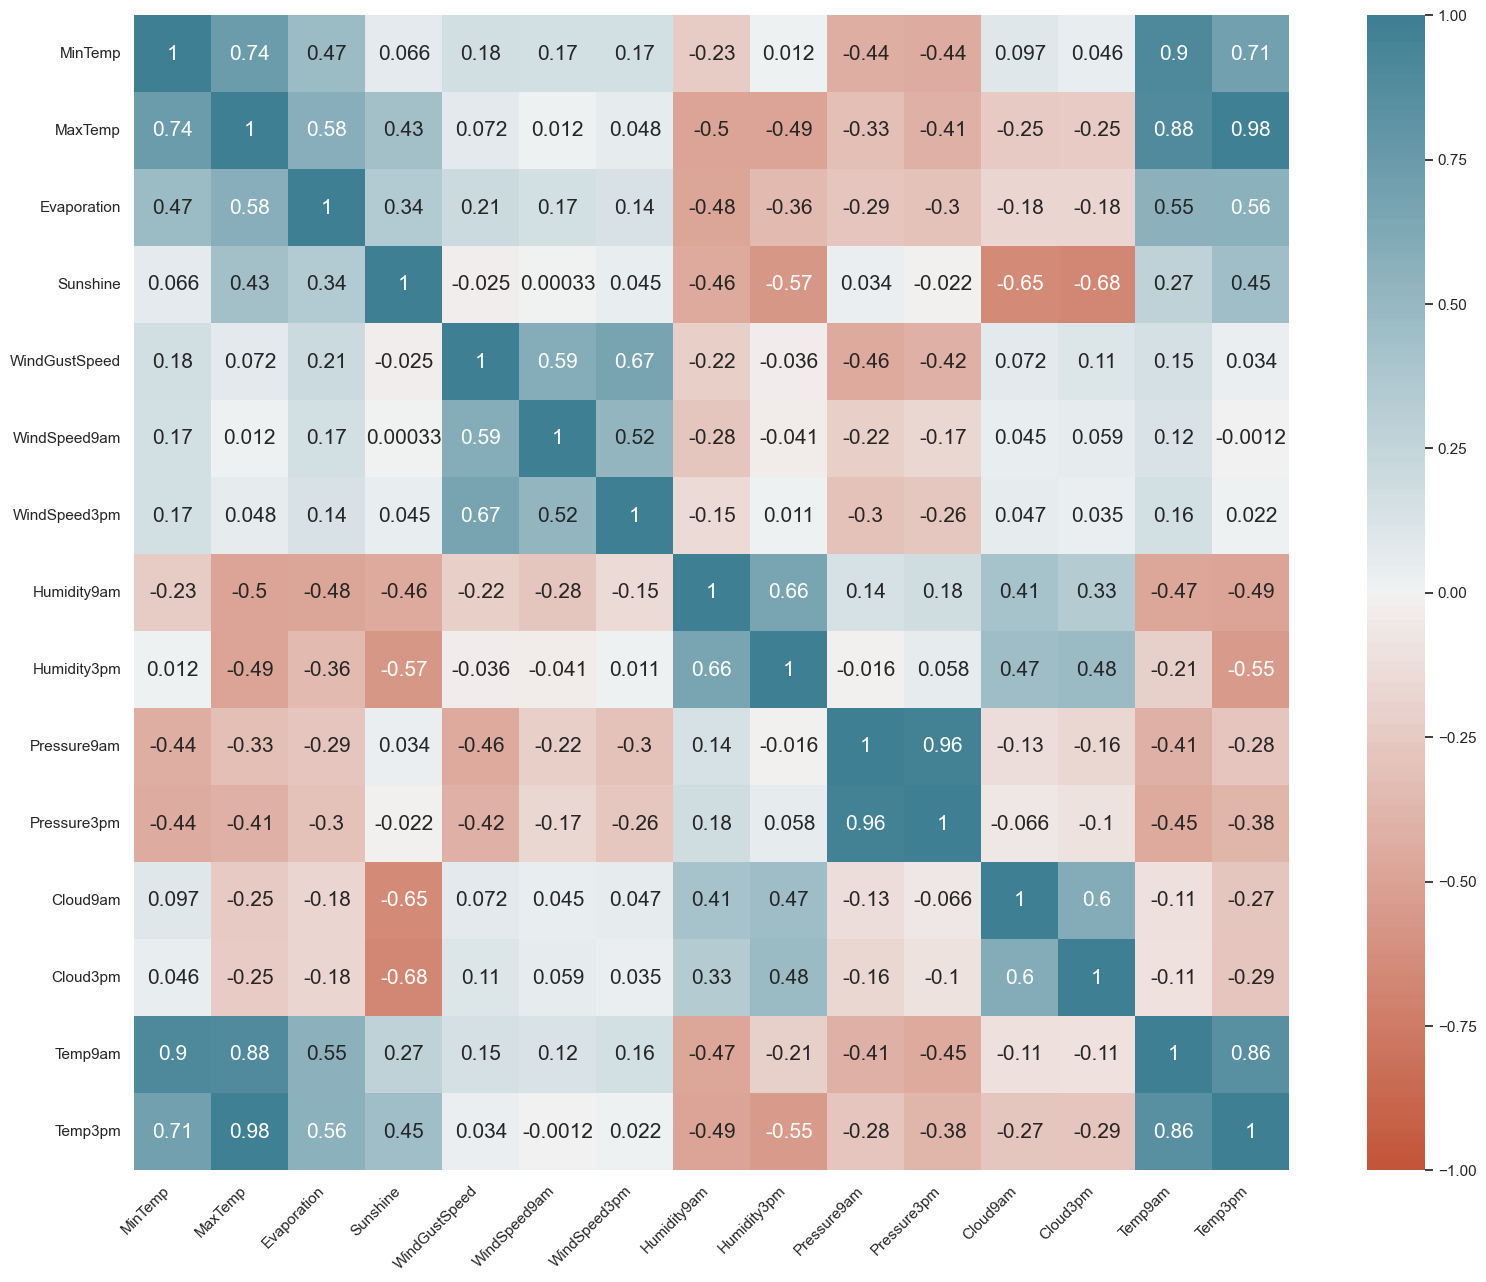

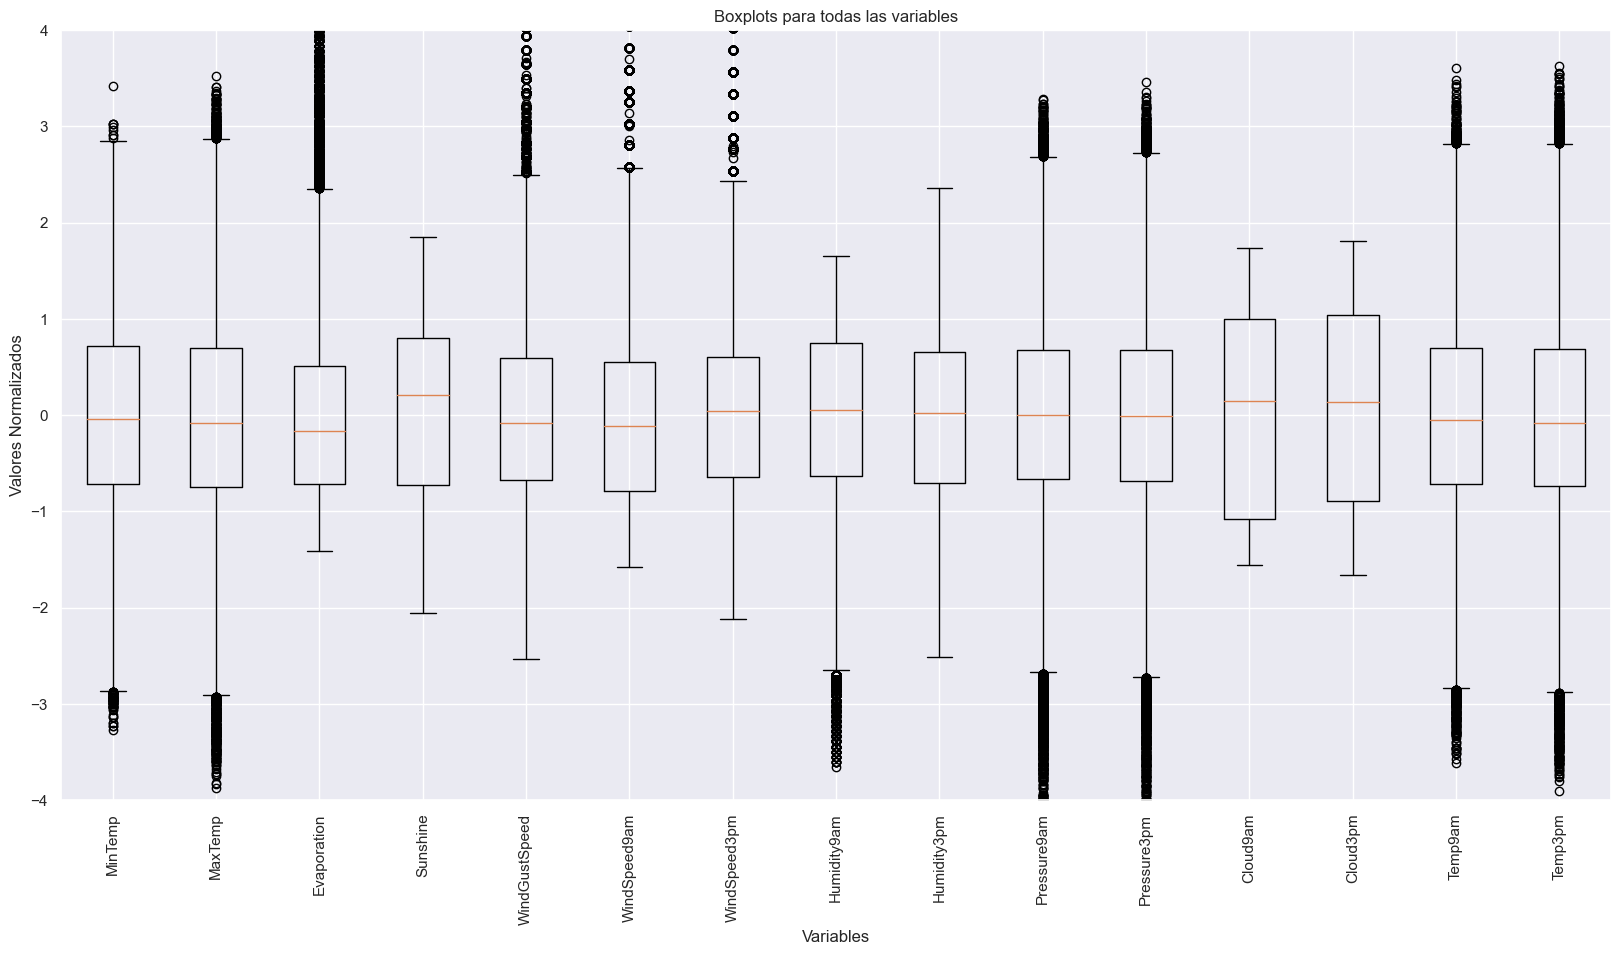

Cantidad de datos disponibles en el DataFrame: 137114


In [113]:
graficos(df)

Podemos usar la misma función para visualizar los datos de un cluster particular.

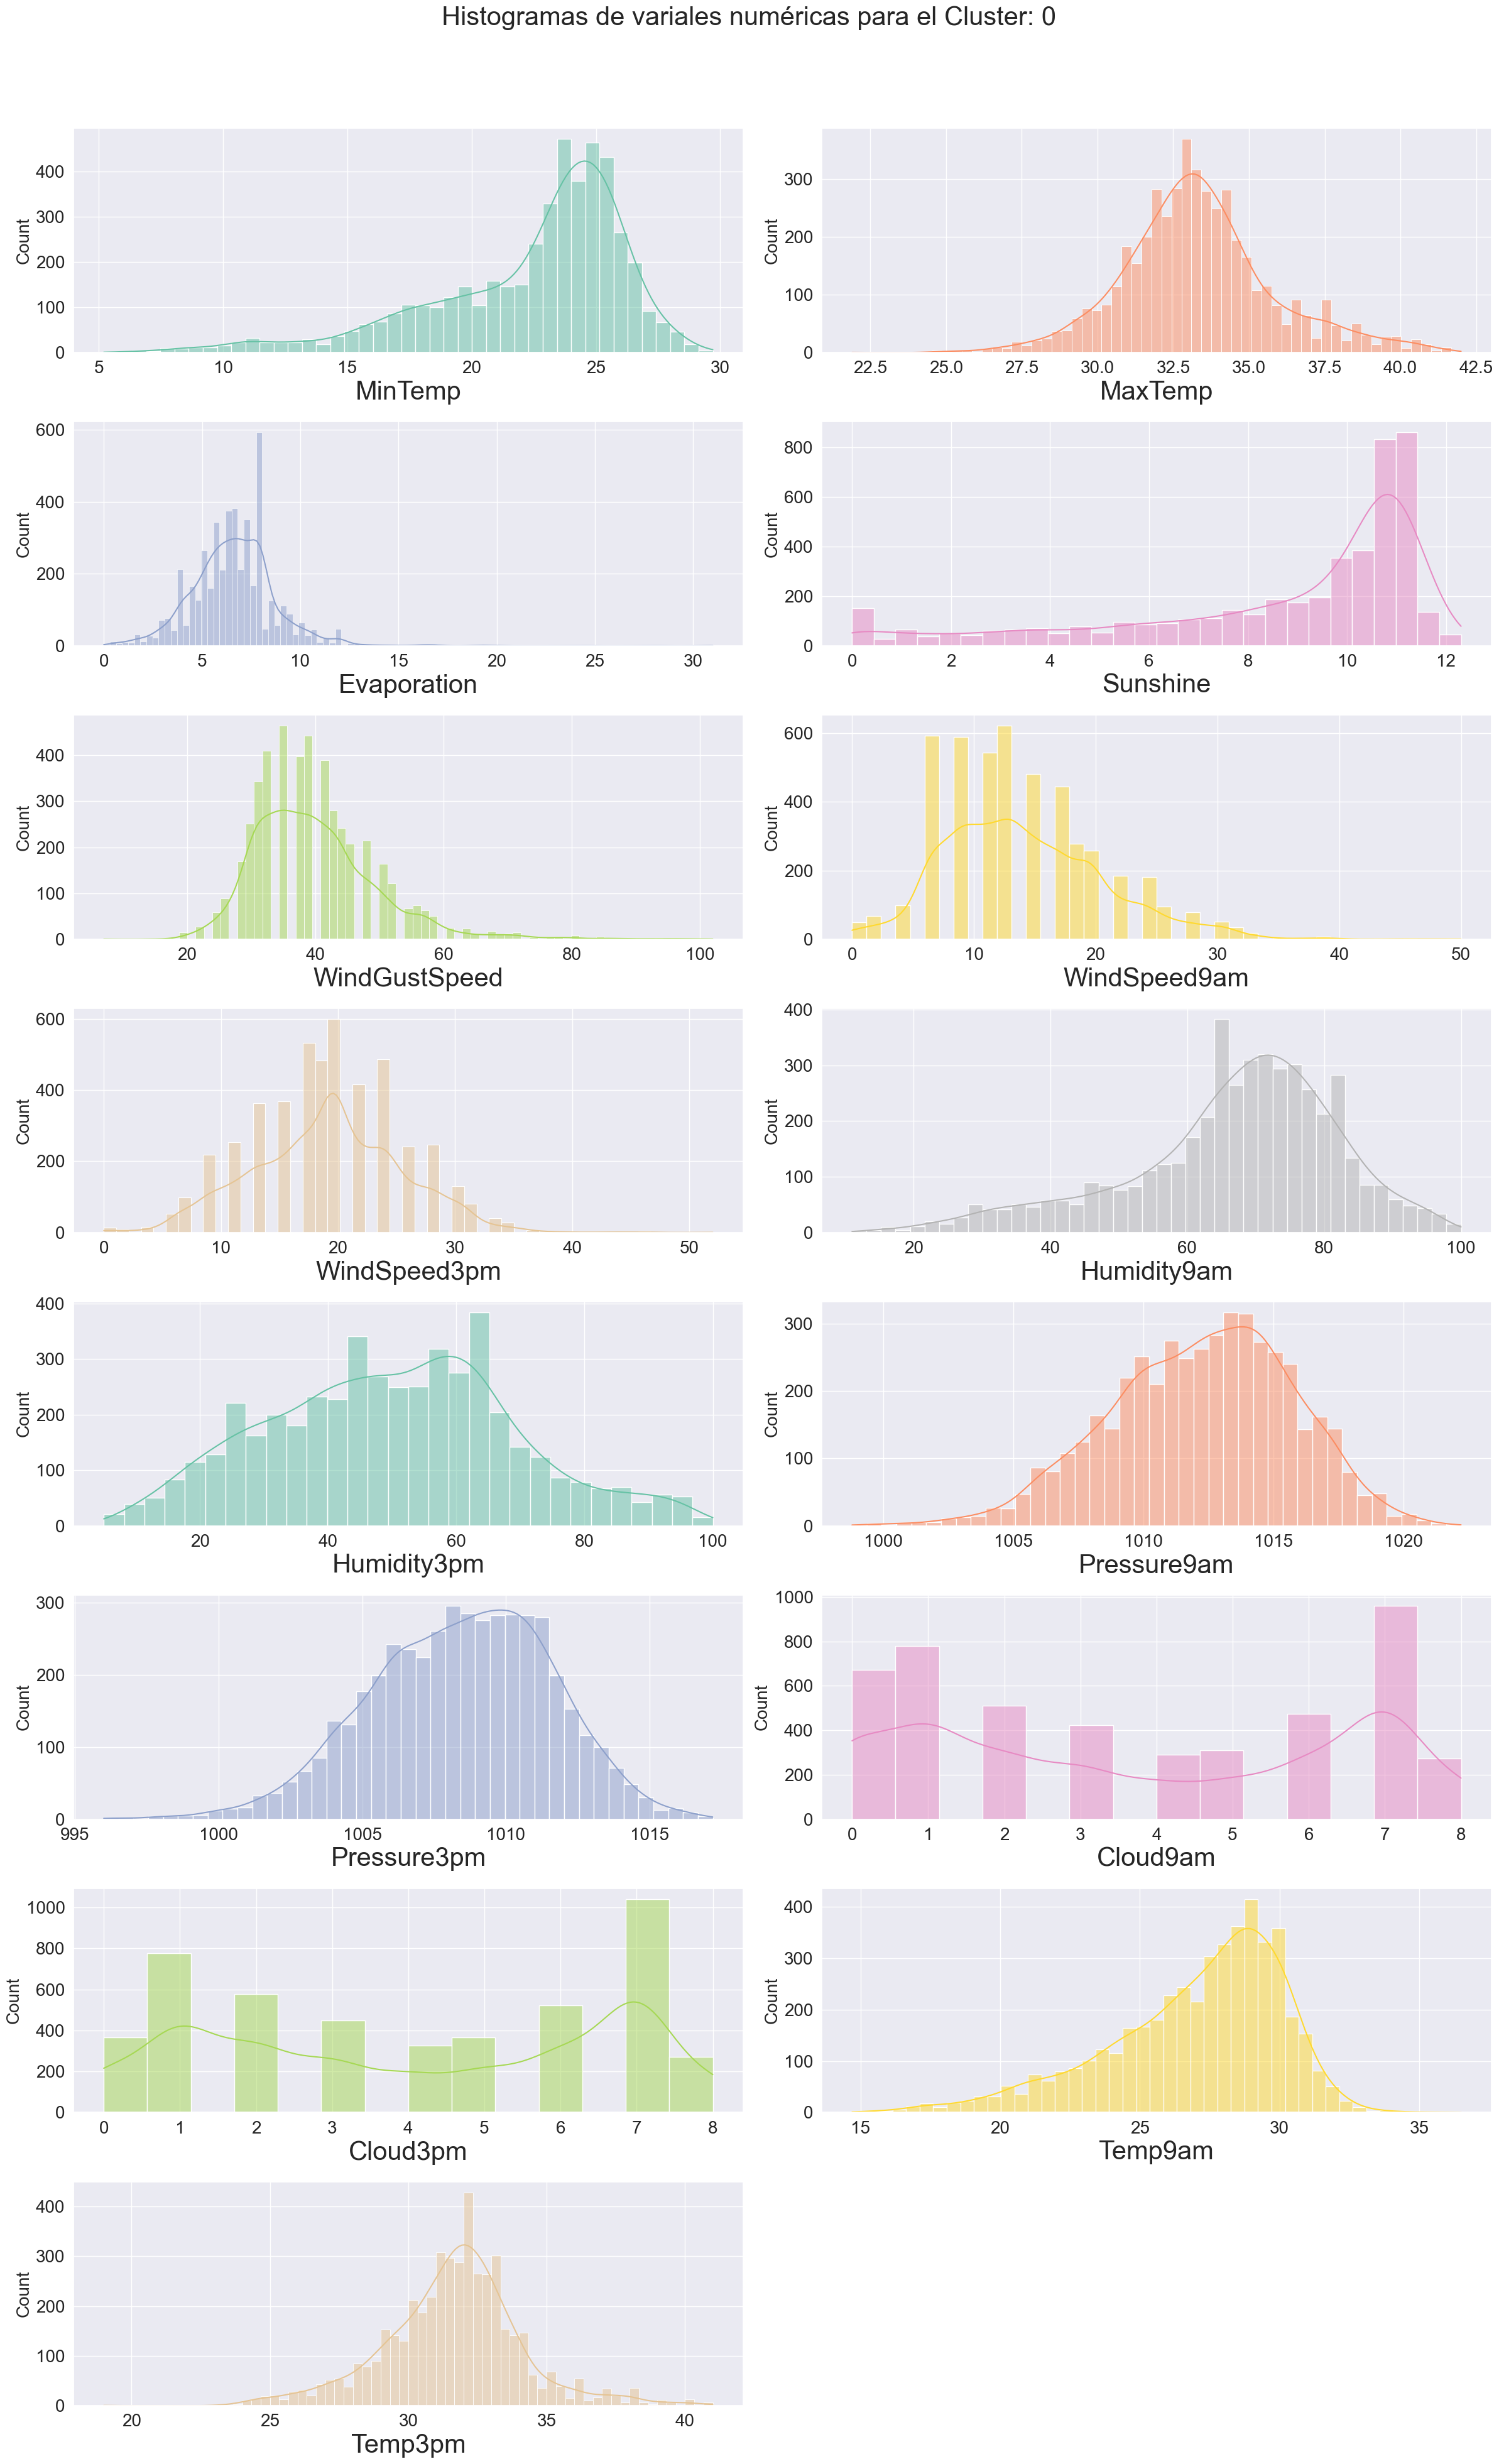

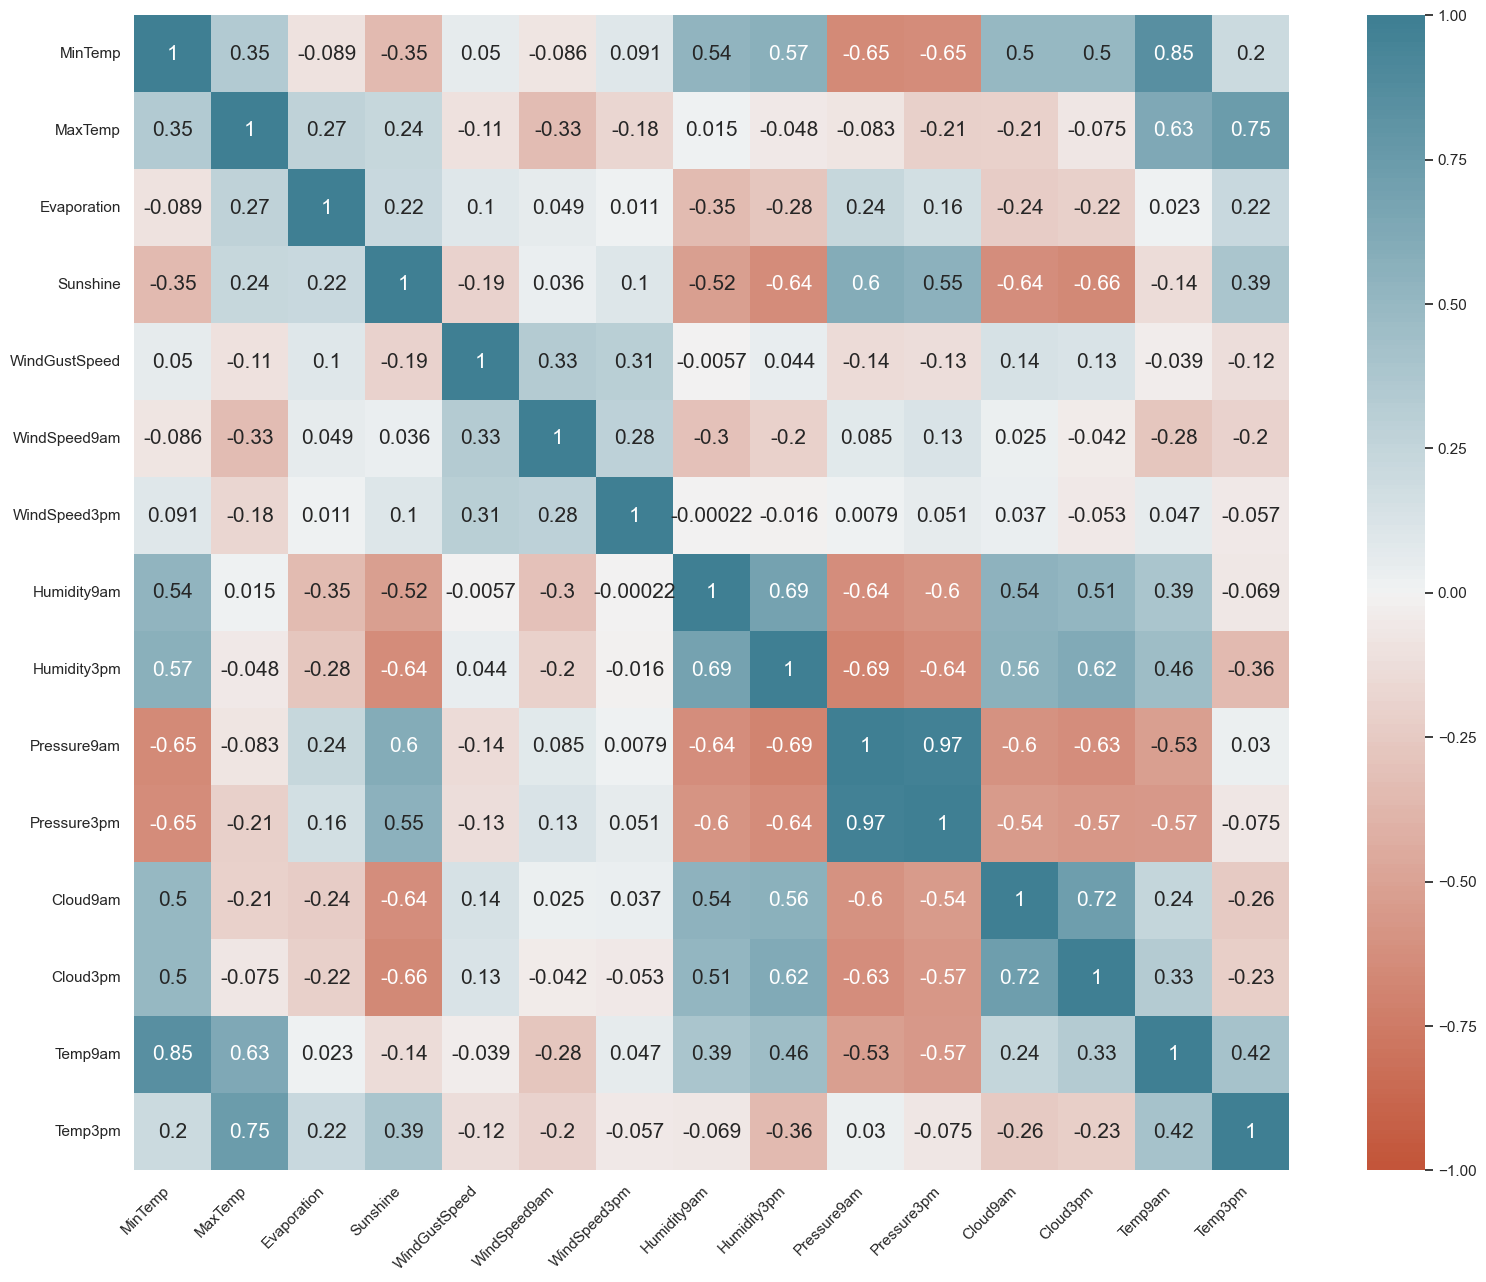

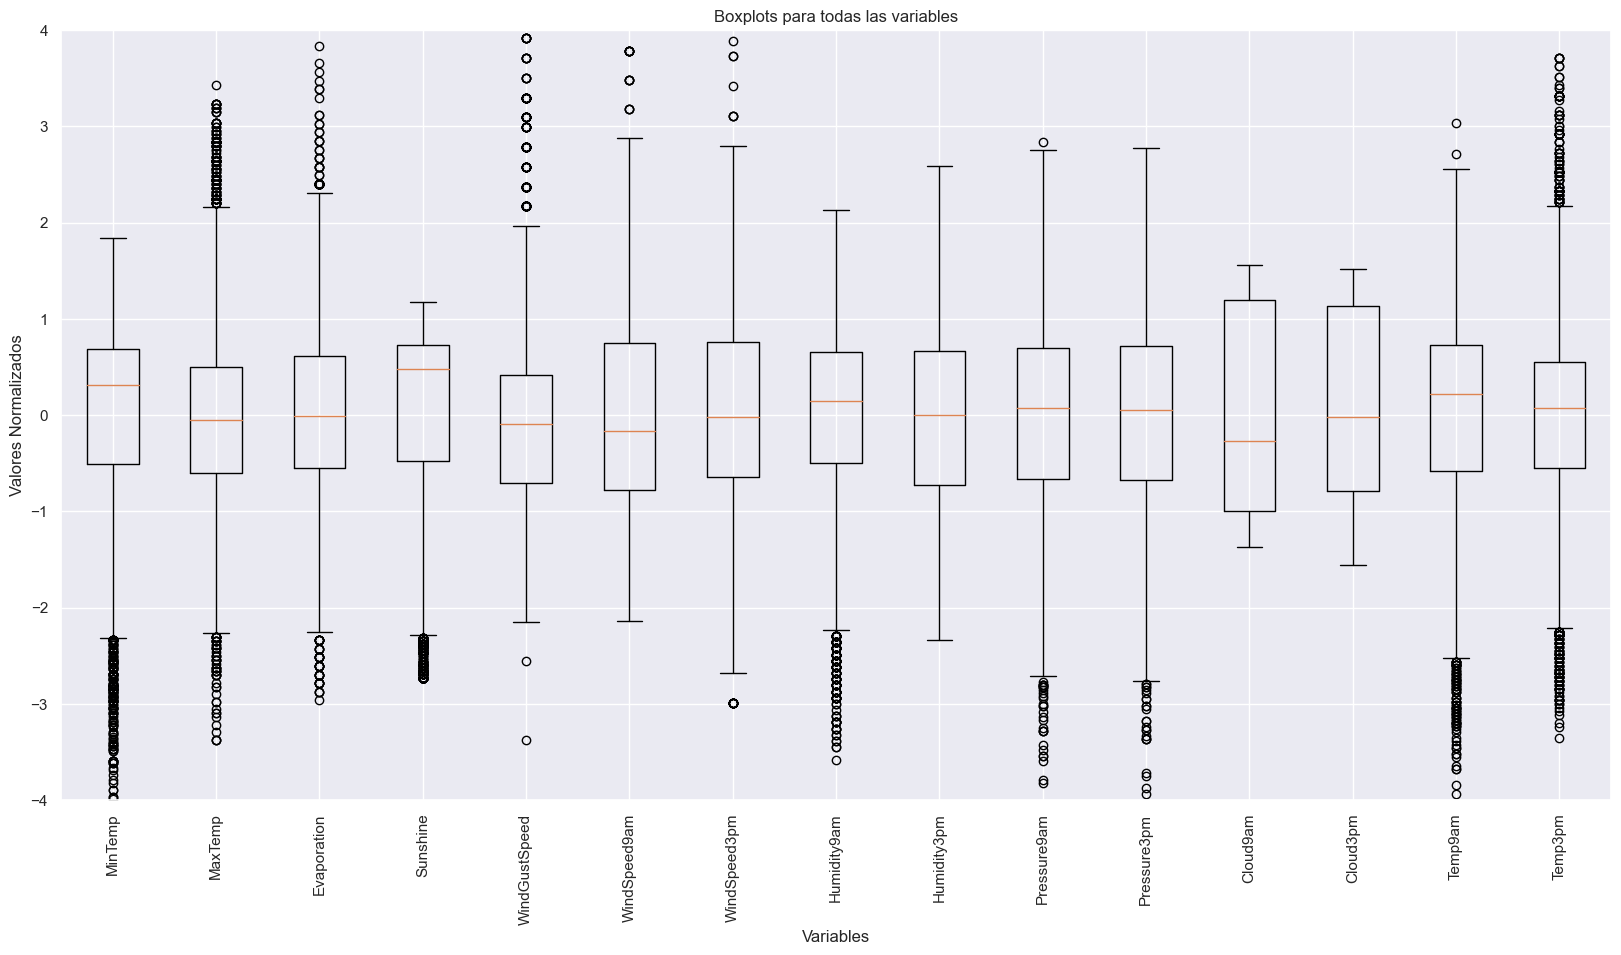

Cantidad de datos disponibles en el DataFrame: 4691


In [114]:
graficos(cluster_dataframe(0))

Y también tenemos un método que nos permite ver los boxplot para un mes particular, en caso de que sea necesario.

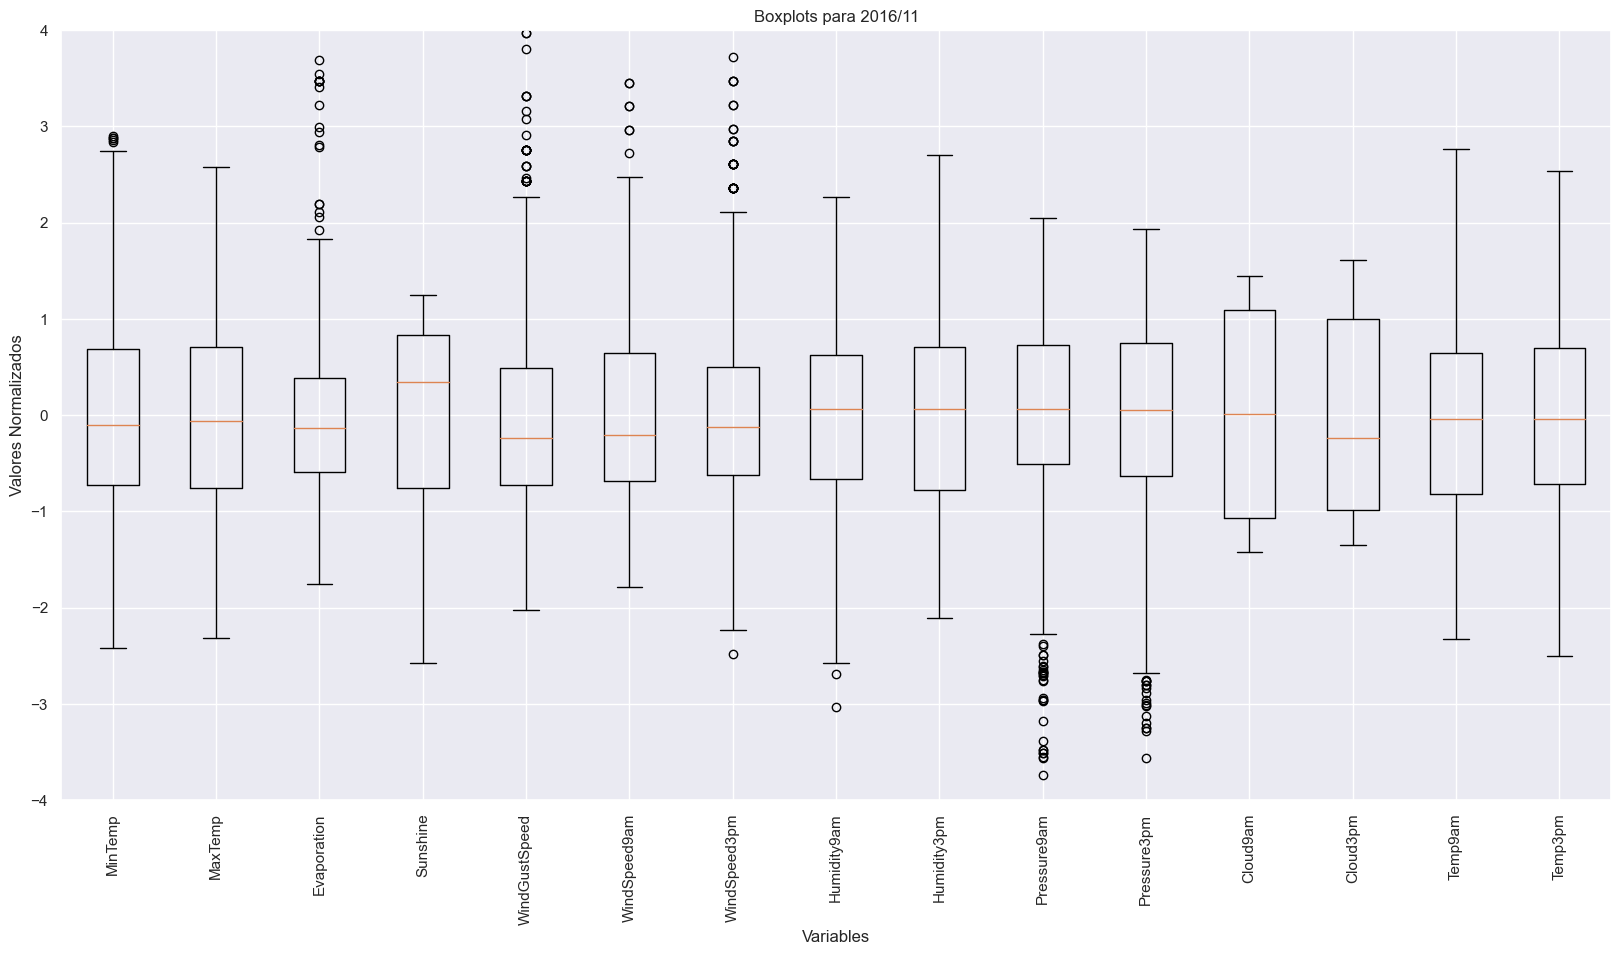

Cantidad de datos disponibles para 2016/11: 992


In [115]:
date_boxplots(df, year=2016, month=11)

## Análisis de Balance ##
Para analizar el balance necesitamos determinar si la distribución de las variables target, en este caso categóricas esta uniformemente distribuida. Para eso diseñamos el siguiente método. Pretendemos que los scores estén cerca de 0.5 lo que representaría una distribución uniforme de los datos.

In [132]:
def check_balance(df, target_columns):

    balance_scores = {}

    for column in target_columns:
        class_counts = df[column].value_counts()
        num_classes = len(class_counts)
        max_count = class_counts.max()
        balance_score = max_count / len(df)
        balance_scores[column] = balance_score

    return balance_scores

target_columns = ["RainToday", "RainTomorrow"]
balance_scores = check_balance(df, target_columns)
print("Balance Scores:")
for column, score in balance_scores.items():
    print(f"{column}: {score}")

Balance Scores:
RainToday: 0.7809510277540969
RainTomorrow: 0.7849610053361119


Dado que los valores rondan el 0.8, los target RainToday y RainTomorrow presentan una distribución no uniforme para sus respectivos valores. Esto quiere decir que el dataset no está balanceado.

## Selección de características ##

In [89]:
# Obtiene una lista de todas las columnas no numéricas del DataFrame
#non_numeric_columns = df.drop(['Unnamed: 0','Rainfall','RainfallTomorrow'],axis=1).select_dtypes(include=[object]).columns
non_numeric_dataframe = df[non_numeric_columns]
non_numeric_dataframe

,Date,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,W,W,WNW,No,No
1,2008-12-02,Albury,WNW,NNW,WSW,No,No
2,2008-12-03,Albury,WSW,W,WSW,No,No
3,2008-12-04,Albury,NE,SE,E,No,No
4,2008-12-05,Albury,W,ENE,NW,No,No
...,...,...,...,...,...,...,...
144981,2016-04-20,Uluru,SSW,S,NE,No,No
144984,2016-04-23,Uluru,E,ESE,ESE,No,No
144985,2016-04-24,Uluru,E,ENE,E,No,No
144986,2016-04-25,Uluru,E,E,NNE,No,No


In [90]:
wind=df['WindGustDir'].unique()
print(wind)

['W' 'WNW' 'WSW' 'NE' 'NNW' 'N' 'NNE' 'SW' 'SSW' 'ENE' 'SSE' 'S' 'NW' 'SE'
 'ESE' 'E']
